In [3]:
import numpy as np
import cv2
import glob
from os import listdir
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [4]:
def calibrateImages(img, objpoints, imgpoints):
    
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    

In [5]:
def undistortImage(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx) 
    


In [6]:


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
calib_images=[]
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    calib_images.append(img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        #cv2.imshow('Undistorted Image', undistorted)

#gray_calib = cv2.cvtColor(calib_images[0],cv2.COLOR_BGR2GRAY)      
ret, mtx, dist, rvecs, tvecs = calibrateImages(calib_images[0], objpoints, imgpoints)


In [15]:
def plotoriginal_vs_processed(originalImage,OriginalImageName, processedImage, processedImageName):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    #cv2.polylines(originalImage,pts, True,(0,255,0),3)
    #cv2.polylines(originalImage,pts2, True,(255,0,0),3)
    ax1.imshow(originalImage)
    ax1.set_title(OriginalImageName, fontsize=12)
    ax2.imshow(processedImage)
    ax2.set_title(processedImageName, fontsize=12)
   

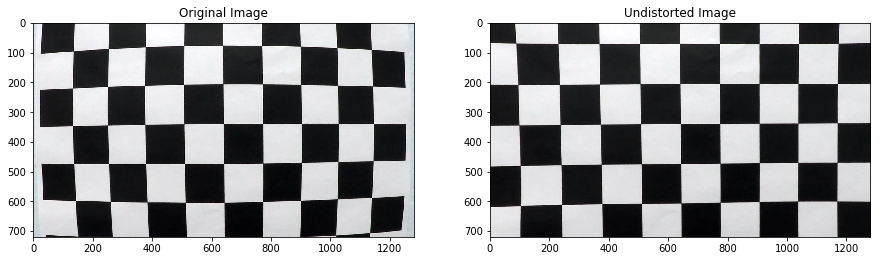

In [71]:
dst = undistortImage(calib_images[0], mtx, dist)  
plotoriginal_vs_processed(calib_images[0], 'Original Image',dst,'Undistorted Image')

In [9]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    abs_sobel = None
    if(orient=='x'):
        abs_sobel=np.absolute(cv2.Sobel(gray,cv2.CV_64F,1,0,ksize=sobel_kernel))
    elif(orient=='y'):
        abs_sobel=np.absolute(cv2.Sobel(gray,cv2.CV_64F,0,1,ksize=sobel_kernel))
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel=np.uint8((255.0*abs_sobel)/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    #print(np.max(scaled_sobel))
    #print(np.max(abs_sobel))
    binary_output=np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <=thresh[1])]=1
    
    #print(binary_output)
    # Apply threshold
    return binary_output

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobel_y=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude 
    magnitude=np.sqrt(np.square(abs_sobel_x)+np.square(abs_sobel_y))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_image=np.uint8(255*magnitude/np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(scaled_image)
    binary_output[(scaled_image>=mag_thresh[0]) & (scaled_image<=mag_thresh[1])]=1
    return binary_output

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobel_x=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,  ksize=sobel_kernel))
    abs_sobel_y=np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,  ksize=sobel_kernel))

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    absgraddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # 5) Create a binary mask where mag thresholds are met
    binary_output=np.zeros_like(absgraddir)
    binary_output[(absgraddir>=thresh[0]) & (absgraddir<=thresh[1])]=1
    # Apply threshold
    return binary_output

def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls=cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel=hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output=np.zeros_like(s_channel)
    # 3) Return a binary image of threshold result
    binary_output[(s_channel>thresh[0]) & (s_channel<=thresh[1])]=1
    #binary_output = np.copy(img) # placeholder line
    return binary_output

In [11]:
def perspectiveTransform(image):
    #src = np.array([[[225, 700], [600,450], [680,450], [1075,700]]])
    #dst= np.array([[[350,700], [350, 0], [900,0], [900,700]]])
    src = np.float32([[230, 693], [591,450], [689,450], [1076,693]])
    dst= np.float32([[350,700], [350, 0], [900,0], [900,700]])
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (image.shape[1], image.shape[0])
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(image, M, img_size)
    return warped,M

In [12]:
def regionOfInterest(image, vertices):
    
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image
    #print(vertices)
    
    #plt.imshow(roiImage, cmap='gray')

In [67]:
def findLines(image):
    histogram = np.sum( image[3*image.shape[0]//4:,:], axis=0)
    #plt.imshow(warped_single_channel,cmap="gray")
    out_img = np.dstack((image, image, image))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    # Set height of windows
    window_height = np.int(image.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(image.shape[0] - (window+1)*window_height)
        win_y_high = int(image.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    

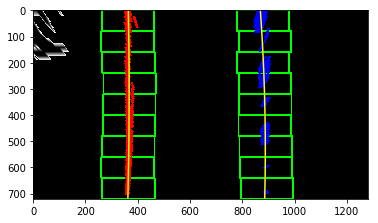

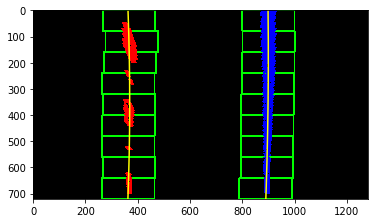

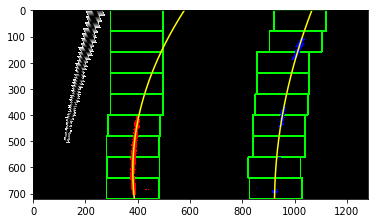

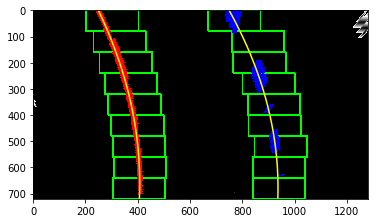

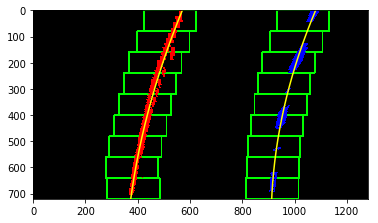

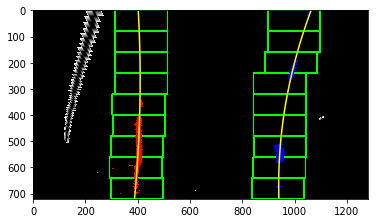

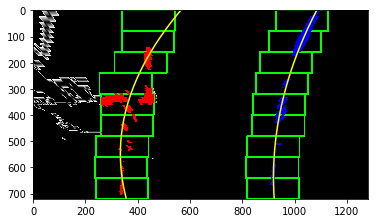

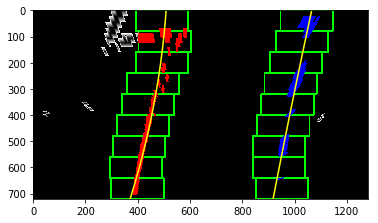

In [70]:
bottom_left_vertex=(120,720)
top_left_vertex=(500,430)
top_right_vertex=(730,430)
bottom_right_vertex=(1200,720)
vertices=np.array([[bottom_left_vertex, top_left_vertex, top_right_vertex, bottom_right_vertex]])
undistorted_output_path="./output_images/undistorted_test_images/"
color_gradient_output_path="./output_images/color_gradient_images/"
warped_binary_output_path="./output_images/warped_images/"
test_images_path="./test_images/"
file_names = listdir(test_images_path)
rows = len(file_names)
for name in file_names:
    test_image = cv2.imread(test_images_path+name)
    BGRtoRGB = cv2.cvtColor(test_image,cv2.COLOR_BGR2RGB)
    undistorted=undistortImage(BGRtoRGB, mtx, dist)
    
    
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=5, thresh=(10, 190))
    grady = abs_sobel_thresh(undistorted, orient='y', sobel_kernel=3, thresh=(20, 180))
    mag_binary = mag_thresh(undistorted, sobel_kernel=3, mag_thresh=(100, 180))
    dir_binary = dir_threshold(undistorted, sobel_kernel=5, thresh=(0.7, 1.2))
    hls_binary=hls_select(undistorted, thresh=(200,255))
    
    combined = np.zeros_like(mag_binary)
    # combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    combined[((mag_binary == 1) | (hls_binary == 1))] = 1
    #gradx=np.uint8(gradx*255)
    color_gradient_result=np.dstack(( combined, combined, combined))*255 
    masked_image=regionOfInterest(color_gradient_result, vertices)
    #plotoriginal_vs_processed(undistorted, "Undistorted Image", color_gradient_result, "color and magnitude gradient",src,dst)
    warped_binary, perspective_result = perspectiveTransform(masked_image)
    #cv2.polylines(undistorted,vertices,True,(0,255,0),3)
    #plotoriginal_vs_processed(undistorted, "Undistorted Image", warped_binary, "Perpective transform")
    #cv2.imwrite(undistorted_output_path+name,undistorted)
    #mpimg.imsave(warped_binary_output_path+"undistorted_"+name,warped_binary)
    plt.show()
    warped_single_channel = warped_binary[:,:,0]
    findLines(warped_single_channel)
    

    